In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
from glob import glob
import re
import argparse
import numpy as np
from tqdm import tqdm
import pandas as pd
import h5py
from Xana import Xana
from functions.metadata import get_rep, get_scan_number
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
datafolder = 'ferritin_conc_gly_50_6'
datasetnumber = 5
repsperspot = 4

In [4]:
filename = f"{datafolder}_{datasetnumber:04}"
print(filename)

ana_db_files = glob(f'/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results_saxs-2/{datafolder}_{datasetnumber:04}/p**/analysis_database.pkl', recursive=True)

xana = Xana()
for i, f in enumerate(ana_db_files):
    if i == 0:
        xana.load_db(f)
    else:
        xana.append_db(f)

# find the error here
xana.db['rep'] = xana.db['master'].apply(lambda x: get_rep(x, reps_per_spot=repsperspot))
xana.db['scannumber'] = xana.db['datdir'].apply(lambda x: get_scan_number(str(x)))


ferritin_conc_gly_50_6_0005
Try loading database:
	/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/results_saxs-2/ferritin_conc_gly_50_6_0005/p413203/analysis_database.pkl
Successfully loaded database


In [5]:
xana.db = xana.db.sort_values(by='scannumber')
saxs_indices = xana.db[xana.db['analysis'] == 'saxs'].index.values
nsaxs = len(saxs_indices)
saxs_scans = xana.db.loc[saxs_indices, 'scannumber'].values
delay = xana.db.loc[saxs_indices, 't_exposure'].values[0]


qI = xana.get_item(saxs_indices[0])['soq'][:,0]
nqI = len(qI)


path = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files-saxs/'
print("\n\npath+filename", path+filename, "\n\n")




path+filename /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files-saxs/ferritin_conc_gly_50_6_0005 




In [6]:
# -- write metadata from elog
# load elog as pd dataframe
print("\nWriting metadata from elog\n")
elog = pd.read_pickle("../03-source/elog")
condition = elog['measurement folder'].str.contains(filename[:-3], na=False) # select the right entry
elog_entries = elog[condition] # select elog entry
print(elog_entries)
print("\nTemp: ", elog_entries["Temperature, K"].values, "\n")    
# -- end of elog writing prep


Writing metadata from elog

                     Sample PostAnalysis  \
130  ferritin_conc_gly_50_6          NaN   
131  ferritin_conc_gly_50_6          NaN   
132  ferritin_conc_gly_50_6         done   
133  ferritin_conc_gly_50_6         done   
134  ferritin_conc_gly_50_6         done   
135  ferritin_conc_gly_50_6         done   
136  ferritin_conc_gly_50_6         done   

                                    comment  \
130                                     NaN   
131                                     NaN   
132  xpcs, 4 reps per spot, 250K, full beam   
133  xpcs, 4 reps per spot, 240K, full beam   
134  xpcs, 4 reps per spot, 230K, full beam   
135  xpcs, 4 reps per spot, 220K, full beam   
136  xpcs, 4 reps per spot, 210K, full beam   

                                 Short comment Sample no. (label)  \
130                                      dscan               10.6   
131                                      dscan               10.6   
132                               

In [7]:
print(f"Create h5 file: {path + filename}", '\n')
nreps = repsperspot
print(f"{delay = }, {nqI = }, {saxs_indices = }, {nsaxs = }, {saxs_scans = }")

Create h5 file: /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files-saxs/ferritin_conc_gly_50_6_0005 

delay = 0.0002, nqI = 1000, saxs_indices = array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262,

In [8]:
# -- saxs
print("\nWriting saxs data")
# I = f.create_dataset('/saxs/I', shape=(nsaxs, nqI), dtype=np.float32, compression="gzip") # all Iqs
# I_rep_filtered = f.create_dataset('/saxs/I_reps_filtered', shape=(args.repsperspot, nqI), dtype=np.float32, compression="gzip") # filtered Iqs
# dI_rep_filtered = f.create_dataset('/saxs/dI_reps_filtered', shape=(args.repsperspot, nqI), dtype=np.float32, compression="gzip") # filtered Iqs

I = np.empty( shape=(nsaxs, nqI)) # all Iqs
I_rep_filtered = np.empty(shape=(nreps, nqI)) # filtered Iqs
dI_rep_filtered = np.empty(shape=(nreps, nqI)) # filtered Iqs



Writing saxs data


In [9]:
for i, saxs_index in tqdm(enumerate(saxs_indices), desc='writing SAXS results',  total=len(saxs_indices)):
    tmp = xana.get_item(saxs_index)
    I[i] = tmp['soq'][:,1]

writing SAXS results: 100%|██████████| 448/448 [00:36<00:00, 12.39it/s]


In [10]:
np.shape(saxs_indices)

(448,)

In [11]:
xana.db.head(21)

,use,sample,analysis,mod,savname,savfile,setupfile,comment,series,t_exposure,t_readout,nframes,master,first,last,datdir,rep,scannumber
0,True,,saxs,2024-11-18 00:29:43.050647,s0001_0000.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,1.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,1
1,True,,saxs,2024-11-18 00:29:51.238538,s0002_0001.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,2.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,2,2
2,True,,saxs,2024-11-18 00:29:59.251293,s0003_0002.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,3.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,3,3
3,True,,saxs,2024-11-18 00:30:08.406069,s0004_0003.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,4.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,4,4
4,True,,saxs,2024-11-18 00:30:16.403399,s0005_0004.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,5.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,5
5,True,,saxs,2024-11-18 00:30:24.419375,s0006_0005.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,6.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,2,6
6,True,,saxs,2024-11-18 00:30:32.411113,s0007_0006.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,7.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,3,7
7,True,,saxs,2024-11-18 00:30:40.397648,s0008_0007.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,8.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,4,8
8,True,,saxs,2024-11-18 00:30:48.387017,s0009_0008.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,9.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,1,9
9,True,,saxs,2024-11-18 00:30:56.350177,s0010_0009.pkl,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/202206...,,10.0,0.0002,0.000003,4990.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,10.0,4999.0,/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/ferrit...,2,10


In [18]:
np.max(saxs_scans)

448

In [43]:
series = np.arange(1,30,1)
reps = [1,2,3,4]

Iq_reps = np.empty(shape=(len(reps), nqI))


for j,rep in enumerate(reps[:]):
    # get scan numbers for the specific repetition
    # saxs_scans_per_rep = xana.db[(xana.db['analysis'] == 'saxs') & (xana.db['rep'] == rep)]['scannumber'].values
    ind_per_rep = xana.db[(xana.db['analysis'] == 'saxs') & (xana.db['rep'] == rep)]['scannumber'].index.values

    Is = [] #np.empty(shape=(len(ind_per_rep), nqI))
    print("\trepetition: ", rep, '\t number of spots: ', len(ind_per_rep))
    
    # for k,ser in enumerate(saxs_scans_per_rep):
    for k,ind in enumerate(ind_per_rep):
        # print(ind)
        Is.append(xana.get_item(ind)['soq'][:,1])

    Iq_reps[j, :] = np.average(Is, axis=0)
    print(rep, np.shape(Is), np.shape(ind_per_rep))


	repetition:  1 	 number of spots:  112
1 (112, 1000) (112,)
	repetition:  2 	 number of spots:  112
2 (112, 1000) (112,)
	repetition:  3 	 number of spots:  112
3 (112, 1000) (112,)
	repetition:  4 	 number of spots:  112
4 (112, 1000) (112,)


In [30]:
np.shape(Is), np.shape(saxs_scans_per_rep)

((112, 1000), (112,))

Text(0, 0.5, 'I(q)')

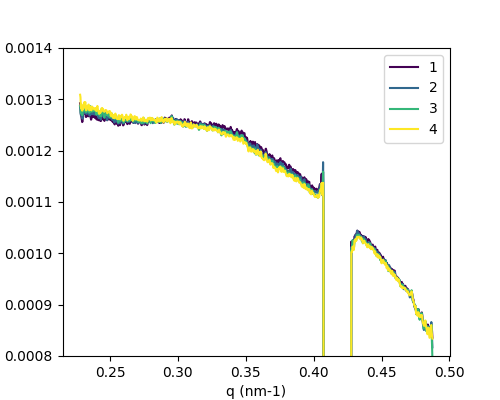

In [52]:
plt.figure(figsize=(5,4))
cols = plt.cm.viridis(np.linspace(0,1,len(reps)))

# for i in range(len(ind_per_rep)):
#     plt.plot(qI, Is[i], c=cols[i])

# plt.plot(qI, np.average(Is, axis=0), c='k', ls="--")

for i in range(len(reps)):
    plt.plot(qI, Iq_reps[i,:], c=cols[i], label=reps[i])

# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.ylim(8e-4, 1.4e-3)
plt.xlabel('q (nm-1)')
plt.ylabel('I(q)')

In [42]:
qI[0]

0.22803482965331312